## imports

In [81]:
import json
import random

import re
import string
import os.path
import timeit
import itertools
from itertools import chain

import numpy as np
import pandas as pd
import _pickle as pickle

import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Embedding, Flatten, LSTM, Bidirectional, TimeDistributed, Dropout, Activation
from keras.layers import LeakyReLU, concatenate

from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

from googletrans import Translator

# initialize the translator
translator = Translator()

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    try:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
    
    # passed pandas dataframe instead of keras.callbacks.History object
    except AttributeError as e:
        acc = history['acc']
        val_acc = history['val_acc']
        loss = history['loss']
        val_loss = history['val_loss']
        
        
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='Training acc')
    plt.plot(x, val_acc, label='Validation acc')
    plt.title('Training vs Validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val_loss, label='Validation loss')
    plt.title('Training vs Validation loss')
    plt.legend()
    
    
def display_cm(cm, labels):
    #plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.xticks(np.arange(len(labels)), labels, rotation=65)
    plt.yticks(np.arange(len(labels)), labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.show()
    

## load data

In [63]:
data_df = pd.read_pickle("data_df_finalV2.pkl")
print(data_df.shape)
data_df.head()

(16705, 13)


,index,id,headline,article,category,url,author,timestamp,source_url,source_url_base,source_article,source_article_dict,source_article_len
0,24823,1503649654769,I once caught woman filming me while I slept o...,Actress Neha Dhupia said she once caught a wom...,entertainment,https://inshorts.com/prev/en/news/i-once-caugh...,Prashanti Moktan,2017-08-25 08:27:34.000Z,http://www.hindustantimes.com/bollywood/neha-d...,www.hindustantimes.com,Neha Dhupia: I once caught a woman filming me ...,{'story_highlight': 'Neha Dhupia: I once caugh...,579
1,313,1517724052573,The nation is obsessed with Big B: Pad Man dir...,"Filmmaker R Balki, while talking about Amitabh...",entertainment,https://inshorts.com/prev/en/news/the-nation-i...,Mriganka Sen,2018-02-04 06:00:52.000Z,https://www.hindustantimes.com/bollywood/natio...,www.hindustantimes.com,‘Nation is obsessed with Amitabh Bachchan’: R ...,{'story_highlight': '‘Nation is obsessed with ...,546
2,15506,1471546262255,NASA plans to sell the ISS by mid-2020s,US space agency NASA plans to hand over contro...,science,https://inshorts.com/prev/en/news/nasa-plans-t...,Satyaki Das,2016-08-18 18:51:02.255Z,https://techcrunch.com/2016/08/18/nasa-hopes-t...,techcrunch.com,NASA hopes to hand the International Space Sta...,{'headline': 'NASA hopes to hand the Internati...,313
3,18010,1527768206107,We've known each other for long: Nidhhi on rum...,"'Munna Michael' actress Nidhhi Agerwal, while ...",entertainment,https://inshorts.com/prev/en/news/weve-known-e...,Daisy Mowke,2018-05-31 12:03:26.000Z,https://www.crictracker.com/nidhhi-agerwal-qua...,www.crictracker.com,We have known each other since our teenage yea...,{'headline': 'We have known each other since o...,334
4,260,1546270256685,MIT scientists develop new 3D-printing system ...,"MIT scientists have developed a new system, G3...",technology,https://inshorts.com/prev/en/news/mit-scientis...,Arundhati Rawat,2018-12-31 15:30:56.000Z,https://techcrunch.com/2018/12/31/mit-research...,techcrunch.com,MIT researchers are now 3D-printing glass\nWhi...,"((headline, MIT researchers are now 3D-printin...",250


In [30]:
data_df = data_df[data_df['source_article']!='NA']
print(data_df.shape)
data_df[['source_article', 'category' , 'source_url_base', 'source_article_len']].head(10)

(16705, 13)


,source_article,category,source_url_base,source_article_len
0,Neha Dhupia: I once caught a woman filming me ...,entertainment,www.hindustantimes.com,579
1,‘Nation is obsessed with Amitabh Bachchan’: R ...,entertainment,www.hindustantimes.com,546
2,NASA hopes to hand the International Space Sta...,science,techcrunch.com,313
3,We have known each other since our teenage yea...,entertainment,www.crictracker.com,334
4,MIT researchers are now 3D-printing glass\nWhi...,technology,techcrunch.com,250
5,Japan Launches Observatory To Study Black Hole...,science,techcrunch.com,459
6,‘Show respect to Tricolour’: BJP leader tweets...,politics,www.timesnownews.com,370
7,Navjot Singh Sidhu has more love and respect i...,politics,www.timesnownews.com,365
8,Mann Ki Baat highlights: PM Modi focuses on Na...,science,www.hindustantimes.com,779
9,"Ikea to enter Indian market in July, may trigg...",business,www.hindustantimes.com,468


In [31]:
# get a sample
def print_sample(pos):
    sample = data_df.iloc[pos][['source_article', 'category', 'source_article_len']]
    print(sample.source_article)
    print('\n-->Category:', sample.category)
        
print_sample(4)

MIT researchers are now 3D-printing glass
While the thought of a machine that can squirt out endless ropes of molten glass is a bit frightening, the folks at MIT have just about perfected the process. In a paper published in 3D Printing and Additive Manufacturing, researchers Chikara Inamura, Michael Stern, Daniel Lizardo, Peter Houk and Neri Oxman describe a system for 3D printing glass that offers far more control over the hot material and the final product.

Their system, called G3DP2, “is a new AM platform for molten glass that combines digitally integrated three-zone thermal control system with four-axis motion control system, introducing industrial-scale production capabilities with enhanced production rate and reliability while ensuring product accuracy and repeatability, all previously unattainable for glass.”

The system uses a closed, heated box that holds the melted glass and another thermally controlled box where it prints the object. A moveable plate drops the object lower

In [64]:
data_df['source_url_base'].value_counts()

www.hindustantimes.com    7030
www.timesnownews.com      3336
www.theguardian.com       1747
techcrunch.com            1713
www.livemint.com          1631
www.crictracker.com        818
phys.org                   430
Name: source_url_base, dtype: int64

In [32]:
data_df['category'].value_counts()

entertainment    4101
business         2855
politics         2755
sports           2750
technology       2569
science          1326
automobile        349
Name: category, dtype: int64

In [33]:
# source article avg length per category
data_df.groupby('category')['source_article_len'].mean()

category
automobile       495.613181
business         509.999650
entertainment    459.719824
politics         511.872232
science          616.055807
sports           474.706182
technology       511.391592
Name: source_article_len, dtype: float64

## pre-processing

In [69]:
# removing stop words and punctiuation
# converting to set to improve search
STOPWORDS = set(stopwords.words('english')) 

def clean_text(text):
    
    #split based on everything except a-z0-9_'.-
    text = re.sub("[.]", "", text)
    tokens = re.findall("[a-z0-9_'.\-]+", text.lower())
    tokens = [w for w in tokens if not w in STOPWORDS and len(w) > 2 and len(w)<20]
    text = " ".join(tokens)
    
    return text

text = "Daimler, which also has licenses in Germany and the U.S., said it will now begin road tests in Beijing. \
        There are other companies testing autonomous vehicles in China, notably Baidu, which has been on public \
        roads since at least 2016. For Daimler to qualify, the company said"

clean_text(text)


'daimler also licenses germany said begin road tests beijing companies testing autonomous vehicles china notably baidu public roads since least 2016 daimler qualify company said'

In [36]:
data_df['source_article'] = data_df['source_article'].apply(lambda x: clean_text(x))
data_df['source_article_len'] = data_df['source_article'].apply(lambda x: len(x.split()))

# 95 percentile article length Decreased
data_df['source_article_len'].quantile(.95)


532.0

In [37]:
data_df['source_article_len'].quantile(.96), data_df['source_article_len'].quantile(.97), \
data_df['source_article_len'].quantile(.98), data_df['source_article_len'].quantile(.99)

(566.0, 615.0, 713.0, 961.6399999999921)

In [38]:
data = data_df[['source_article', 'category', 'source_article_len']]
data.head()

,source_article,category,source_article_len
0,neha dhupia caught woman filming flight asleep...,entertainment,292
1,nation obsessed amitabh bachchan balki reveals...,entertainment,285
2,nasa hopes hand international space station co...,science,183
3,known since teenage years says nidhi agerwal r...,entertainment,164
4,mit researchers 3d-printing glass thought mach...,technology,151


In [39]:
sorted(data['category'].unique())

['automobile',
 'business',
 'entertainment',
 'politics',
 'science',
 'sports',
 'technology']

In [40]:
data[data['source_article_len']==0]

,source_article,category,source_article_len


## tokenizing

In [42]:
# getting tokens

# all tokens
tokens_all = list(chain.from_iterable([article.split() for article in data['source_article']]))

# unique tokens
tokens = list(set(tokens_all))

# will be used for handling unknown tokens
tokens.append("UNK")

# will be used for padding
tokens.append("ENDPAD")

VOCAB_SIZE = len(tokens)

# classes: sorted(data['category'].unique())
classes = sorted(data['category'].unique())

NUM_CLASSES = len(classes)

print("Total number of tokens:", len(tokens_all))
print("Number of unique tokens:", VOCAB_SIZE)
print("Number of classes:", NUM_CLASSES)


Total number of tokens: 4802704
Number of unique tokens: 157877
Number of classes: 7


In [43]:
# converting tokens, class to indices

MAX_SENT_LEN = 600

word2idx = {w: i for i, w in enumerate(tokens)}
class2idx = {t: i for i, t in enumerate(classes)}

# getting x, y as indexes
x = [[word2idx[w] for w in article.split()] for article in data['source_article']]
y = [class2idx[c] for c in data['category']]

# padding x
x_padded = pad_sequences(x, maxlen = MAX_SENT_LEN, padding = "post", value = word2idx['ENDPAD'], truncating = "post")

# one hot encoding for y
y_ohe = to_categorical(y, num_classes= NUM_CLASSES)


### saving tokenizer

In [44]:
dictionary = {"word2idx": word2idx,
              "class2idx": class2idx,
              "VOCAB_SIZE": VOCAB_SIZE,
              "NUM_CLASSES": NUM_CLASSES,
              "MAX_SENT_LEN": MAX_SENT_LEN,
              }

output = open("data-pickle.txt", "wb")
pickle.dump(dictionary, output)
output.close()

In [45]:
data.head(10)

,source_article,category,source_article_len
0,neha dhupia caught woman filming flight asleep...,entertainment,292
1,nation obsessed amitabh bachchan balki reveals...,entertainment,285
2,nasa hopes hand international space station co...,science,183
3,known since teenage years says nidhi agerwal r...,entertainment,164
4,mit researchers 3d-printing glass thought mach...,technology,151
5,japan launches observatory study black holes d...,science,269
6,show respect tricolour bjp leader tweets pic r...,politics,226
7,navjot singh sidhu love respect pakistan india...,politics,212
8,mann baat highlights modi focuses nari shakti ...,science,452
9,ikea enter indian market july may trigger pric...,business,297


In [46]:
print(sorted([(class2idx[c], c) for c in classes]))
print(y[:10])
print(y_ohe[:10])

[(0, 'automobile'), (1, 'business'), (2, 'entertainment'), (3, 'politics'), (4, 'science'), (5, 'sports'), (6, 'technology')]
[2, 2, 4, 2, 6, 4, 3, 3, 4, 1]
[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


In [47]:
print("ENDPAD index:", word2idx['ENDPAD'], "UNK index:", word2idx['UNK'], "vocab length:", VOCAB_SIZE)
print("Class:", sorted([(class2idx[c], c) for c in classes]))

print("\n W/o padding")
print(y[2], y_ohe[2], len(x[2]), "\n", x[2])

print("\n With padding")
print(y[2],  y_ohe[2], len(x_padded[2]), "\n", x_padded[2])


ENDPAD index: 157876 UNK index: 157875 vocab length: 157877
Class: [(0, 'automobile'), (1, 'business'), (2, 'entertainment'), (3, 'politics'), (4, 'science'), (5, 'sports'), (6, 'technology')]

 W/o padding
4 [0. 0. 0. 0. 1. 0. 0.] 183 
 [33128, 63422, 81753, 25199, 154777, 90736, 71081, 142028, 37493, 52293, 33128, 69014, 45473, 118675, 42590, 55515, 61116, 48070, 137924, 55974, 38653, 61116, 140809, 96805, 33128, 77875, 127880, 150215, 37096, 99750, 20626, 127443, 76815, 43052, 69206, 130723, 81753, 81994, 25199, 154777, 90736, 71081, 142028, 54569, 51174, 37493, 156092, 33128, 9208, 84011, 65123, 20626, 59483, 8515, 76815, 114048, 127244, 76178, 33128, 141780, 536, 94566, 18180, 61116, 129118, 136893, 107459, 81753, 154777, 90736, 110810, 71081, 90065, 71081, 153446, 96636, 154974, 59483, 8515, 96636, 154974, 59483, 21662, 55665, 44364, 30210, 43334, 12027, 69206, 7957, 106408, 129379, 132739, 31158, 75312, 144354, 108614, 27866, 69050, 119904, 137795, 625, 153965, 23865, 91104, 104

In [48]:
print(len(x), len(y), x_padded.shape, y_ohe.shape)

16705 16705 (16705, 600) (16705, 7)


In [49]:
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_ohe, test_size = 0.2, shuffle = False)

print(y[9])
print(y_train[9])

1
[0. 1. 0. 0. 0. 0. 0.]


In [50]:
print("x_train:", type(x_train), x_train.shape)
print("y_train:", type(y_train), y_train.shape)

print("\nx_test:", type(x_test), x_test.shape)
print("y_test_ohe:", type(y_test), y_test.shape)


x_train: <class 'numpy.ndarray'> (13364, 600)
y_train: <class 'numpy.ndarray'> (13364, 7)

x_test: <class 'numpy.ndarray'> (3341, 600)
y_test_ohe: <class 'numpy.ndarray'> (3341, 7)


In [51]:
# verifying train-test distribution
df_train = data[:13364]
df_test = data[13364:]

df_train['category_idx'] = df_train['category'].apply(lambda x: class2idx[x])
df_test['category_idx'] = df_test['category'].apply(lambda x: class2idx[x])

print((df_train['category_idx'].values == y_train.argmax(axis=1)).all())
print((df_test['category_idx'].values == y_test.argmax(axis=1)).all())
print("\n")

print(df_train['category'].value_counts(1), "\n") 
print(df_test['category'].value_counts(1))

True
True


entertainment    0.244987
business         0.172104
sports           0.165070
politics         0.163349
technology       0.154145
science          0.079692
automobile       0.020652
Name: category, dtype: float64 

entertainment    0.247531
politics         0.171206
business         0.166118
sports           0.162826
technology       0.152350
science          0.078120
automobile       0.021850
Name: category, dtype: float64


/home/vivek.a/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/vivek.a/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## model

In [54]:
# creating model 
input = Input(shape=(MAX_SENT_LEN,))

model = Embedding(input_dim = VOCAB_SIZE, output_dim = 50, input_length = MAX_SENT_LEN)(input)
model = Dropout(0.2)(model)

model = Bidirectional(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))(model)
out = Dense(NUM_CLASSES, activation="softmax")(model)  

model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 600, 50)           7893850   
_________________________________________________________________
dropout_3 (Dropout)          (None, 600, 50)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               120800    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1407      
Total params: 8,016,057
Trainable params: 8,016,057
Non-trainable params: 0
_________________________________________________________________


In [56]:
model_save_path = "modelsV1/"

EPOCHS = 10
BATCH_SIZE = 64

# creating checkpoint to save model every time validation accuracy improves
filepath = model_save_path + "val_acc-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

print('\n\nTraining Model...')

history1 = model.fit(x_train, y_train,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = callbacks_list,
              validation_data = (x_test, y_test))




Training Model...
Train on 13364 samples, validate on 3341 samples
Epoch 1/10
13364/13364 [==============================] - 259s 19ms/step - loss: 1.1072 - acc: 0.6111 - val_loss: 0.4492 - val_acc: 0.8686

Epoch 00001: val_acc improved from -inf to 0.86860, saving model to modelsV1/val_acc-improvement-01-0.8686.hdf5
Epoch 2/10
13364/13364 [==============================] - 260s 19ms/step - loss: 0.3574 - acc: 0.8947 - val_loss: 0.3094 - val_acc: 0.9150

Epoch 00002: val_acc improved from 0.86860 to 0.91500, saving model to modelsV1/val_acc-improvement-02-0.9150.hdf5
Epoch 3/10
13364/13364 [==============================] - 260s 19ms/step - loss: 0.1825 - acc: 0.9502 - val_loss: 0.2593 - val_acc: 0.9261

Epoch 00003: val_acc improved from 0.91500 to 0.92607, saving model to modelsV1/val_acc-improvement-03-0.9261.hdf5
Epoch 4/10
13364/13364 [==============================] - 261s 20ms/step - loss: 0.0870 - acc: 0.9779 - val_loss: 0.2481 - val_acc: 0.9282

Epoch 00004: val_acc improved

In [57]:
y_pred = model.predict(x_test)
#y_predicted = y_predicted.argmax(axis= 1)

print(y_test.shape, y_pred.shape)
print(y_test.argmax(axis= 1).shape, y_pred.argmax(axis= 1).shape)

print ('\nClassification Report:')
print (classification_report(y_test.argmax(axis= 1), y_pred.argmax(axis= 1)))

print ('\nConfusion Matrix:')
confusion_mat = confusion_matrix(y_test.argmax(axis= 1), y_pred.argmax(axis= 1))
pd.DataFrame(confusion_mat, columns = classes, index = classes)

(3341, 7) (3341, 7)
(3341,) (3341,)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.63      0.68        73
           1       0.87      0.89      0.88       555
           2       0.97      0.94      0.96       827
           3       0.92      0.97      0.94       572
           4       0.91      0.91      0.91       261
           5       0.97      0.97      0.97       544
           6       0.88      0.88      0.88       509

   micro avg       0.92      0.92      0.92      3341
   macro avg       0.90      0.88      0.89      3341
weighted avg       0.92      0.92      0.92      3341


Confusion Matrix:


,automobile,business,entertainment,politics,science,sports,technology
automobile,46,12,0,1,2,0,12
business,6,494,2,17,3,5,28
entertainment,1,12,781,20,0,10,3
politics,0,10,6,553,1,1,1
science,1,3,2,2,237,1,15
sports,0,3,7,4,2,525,3
technology,8,32,4,2,15,1,447


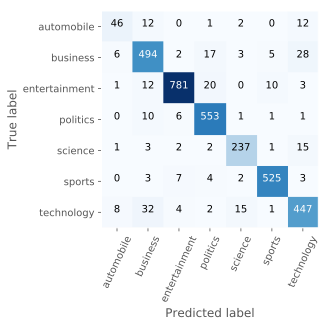

In [62]:
display_cm(confusion_mat, classes)

In [2]:
hist = pd.DataFrame(history1.history)
hist.tail(5)

NameError: name 'history1' is not defined

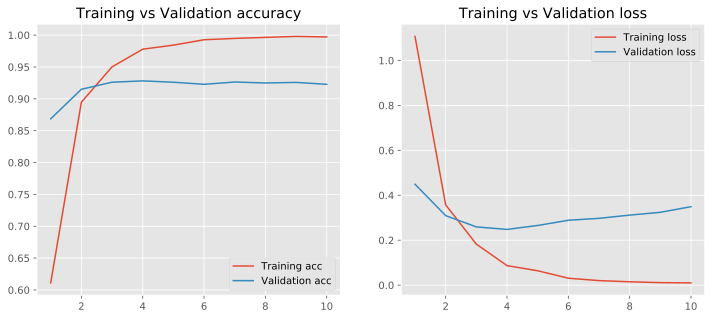

In [61]:
plot_history(hist)

### free model

In [67]:
from keras import backend as K
K.clear_session()

In [68]:
from numba import cuda
cuda.select_device(1)
cuda.close()

## load hindi data

In [28]:
data_hindi = pd.read_pickle("data/hindi/data_df_hi.pkl")
print(data_hindi.shape)
data_hindi = data_hindi.sample(frac=1).reset_index(drop = True)
data_hindi.head(10)

(1026, 11)


,id,headline,article,category,url,author,timestamp,source_url,source_url_base,source_article,source_article_dict
0,1556388115377,बेवकूफों ने मेरी बेटी को बीच में घसीटा इसलिए च...,ट्रोलर्स द्वारा मज़ाक बनाए जाने के बाद अपने गे...,sports,https://inshorts.com/prev/hi/news/%E0%A4%AC%E0...,श्वेता वत्स,2019-04-27 18:01:55.000Z,https://www.crictracker.com/ashok-dinda-reveal...,www.crictracker.com,,{}
1,1556206418619,'खलीबली' का हुक स्टेप करते हुए शिखर धवन व रणवी...,बल्लेबाज़ शिखर धवन ने इंस्टाग्राम पर रणवीर सिं...,entertainment,https://inshorts.com/prev/hi/news/%E0%A4%96%E0...,श्वेता वत्स,2019-04-25 15:33:38.000Z,https://www.hindustantimes.com/bollywood/ranve...,www.hindustantimes.com,,{}
2,1555521385544,मैं सिर्फ छोटा सा फर्स्ट-ऐड किट हूं जो टीम के ...,विश्व कप 2019 के लिए 15 सदस्यीय भारतीय टीम में...,sports,https://inshorts.com/prev/hi/news/%E0%A4%AE%E0...,गौरव तिवारी,2019-04-17 17:16:25.000Z,https://www.crictracker.com/i-am-just-the-smal...,www.crictracker.com,,{}
3,1552730531458,अगर इस साल नहीं तो अगले साल ज़रूर भारत आना पसंद...,टेस्ला के सीईओ एलन मस्क ने कहा है कि अगर इस सा...,automobile,https://inshorts.com/prev/hi/news/%E0%A4%85%E0...,श्वेता वत्स,2019-03-16 10:02:11.000Z,https://www.livemint.com/companies/news/tesla-...,www.livemint.com,,{}
4,1554554501478,45 दिन के भीतर नष्ट हो जाएगा ASAT परीक्षण से उ...,भारत के ऐंटी-सैटेलाइट (ASAT) मिशन के सफल परीक्...,technology,https://inshorts.com/prev/hi/news/45-%E0%A4%A6...,श्वेता वत्स,2019-04-06 12:41:41.000Z,,entrackr.com,,{}
5,1539772490628,एक दिन ऐसा आएगा जब अंतरिक्ष में एक खरब लोग रहे...,एमेज़ॉन के सीईओ जेफ बेज़ोस का दावा है कि एक दि...,science,https://inshorts.com/prev/hi/news/%E0%A4%8F%E0...,श्वेता वत्स,2018-10-17 10:34:50.000Z,https://www.dailymail.co.uk/sciencetech/articl...,www.dailymail.co.uk,,{}
6,1555852361390,"'छपाक' के सेट से लीक हुआ वीडियो, स्कूल ड्रेस म...",दीपिका पादुकोण की आगामी फिल्म 'छपाक' के सेट से...,entertainment,https://inshorts.com/prev/hi/news/%E0%A4%9B%E0...,रुचिका सैनी,2019-04-21 13:12:41.000Z,https://www.hindustantimes.com/bollywood/deepi...,www.hindustantimes.com,,{}
7,1556726040450,"18 साल बाद एरिक श्मिट छोड़ेंगे गूगल बोर्ड, 10 स...",गूगल की पेरेंट कंपनी अल्फाबेट ने बताया है कि ए...,technology,https://inshorts.com/prev/hi/news/18-%E0%A4%B8...,रौनक राज,2019-05-01 15:54:00.000Z,https://www.financialexpress.com/hindi/busines...,www.financialexpress.com,,{}
8,1556681026125,अभद्र टिप्पणी को लेकर गुजरात बीजेपी चीफ के प्र...,गुजरात बीजेपी अध्यक्ष जीतू वाघाणी द्वारा सूरत ...,politics,https://inshorts.com/prev/hi/news/%E0%A4%85%E0...,वेद प्रकाश शर्मा,2019-05-01 03:23:46.000Z,https://www.livehindustan.com/lok-sabha-electi...,www.livehindustan.com,,{}
9,1556680855859,गुड़गांव लोकसभा क्षेत्र के फिरोजपुर झिरका से व...,गुड़गांव लोकसभा सीट के अंतर्गत आने वाले फिरोजप...,politics,https://inshorts.com/prev/hi/news/%E0%A4%97%E0...,सुधीर गहलोत,2019-05-01 03:20:55.000Z,https://www.jagran.com/haryana/gurgaon-lok-sab...,www.jagran.com,,{}


In [31]:
k = 0
data_hindi.iloc[k].article, data_hindi.iloc[k].category  

('ट्रोलर्स द्वारा मज़ाक बनाए जाने के बाद अपने गेंदबाज़ी आंकड़े शेयर कर उन्हें अपना नाम ना लेने के लिए कहने वाले पेसर अशोक डिंडा ने कहा है कि वह चुप नहीं रह सकते थे क्योंकि \'बेवकूफों\' ने उनकी बेटी को बीच में घसीटा था। उन्होंने कहा, "कुछ लोगों ने मेरी बेटी, पत्नी और मां पर भद्दी टिप्पणी की...जो अस्वीकार्य है।"',
 'sports')

In [108]:
data_hindi2 = pd.read_pickle("data/hindi/data_df_hi_s.pkl")
data_hindi2.head(10)

,article,article_en,org_cat,pred_cat
0,चेन्नई सुपर किंग्स के कप्तान महेंद्र सिंह धोनी...,Chennai Super Kings captain Mahendra Singh Dho...,sports,
1,वॉल्वो ने 2020 से अपनी सभी कारों की टॉप स्पीड ...,Volvo has announced to limit its speed of 180 ...,automobile,
2,खराब Pixel 3 फोन के लिए रिफंड नहीं मिलने के बा...,After getting a refund for a bad Pixel 3 phone...,technology,
3,दिल्ली के मुख्यमंत्री अरविंद केजरीवाल ने वाराण...,Delhi Chief Minister Arvind Kejriwal has said ...,politics,
4,अमेरिका ने घोषणा की है कि वह इस साल 2 मई के बा...,The United States has announced that it will n...,business,
5,अभिनेता से नेता बने गुरदासपुर (पंजाब) से बीजेप...,Actor-turned politician from Gurdaspur (Punjab...,entertainment,
6,ऑडी ने ऐसा टूल बनाया है जो ड्राइवर को रेड ट्रै...,Audi has developed a tool that would suggest a...,automobile,
7,नैशनल कॉन्फ्रेंस के उपाध्यक्ष उमर अब्दुल्ला ने...,"Addressing a public meeting on Saturday, Vice ...",politics,
8,सूरत (गुजरात) की एक अदालत ने गुरुवार को कांग्र...,"On Thursday, a court in Surat (Gujarat) sent s...",politics,
9,बल्लेबाज़ शिखर धवन ने इंस्टाग्राम पर रणवीर सिं...,Billybaz Shikhar Dhawan has posted two videos ...,sports,


In [100]:
n = len(data_hindi2)

for i in range(384, len(data_hindi2)):
    article = data_hindi2.iloc[i].article
    article_en = data_hindi2.iloc[i].article_en
    category = data_hindi2.iloc[i].org_cat
    
    # if passing hindi article
    # pred_category = make_prediction(article, category, needTranslation=True, verbose=False)
    
    # only if source is translated    
    if article_en != -1:
        pred_category = make_prediction(article_en, category, verbose=False)
    
    else:
        pred_category = -1
    
    # source couldn't be translated
    if pred_category == -1:
        n -= 1
    
    if category == pred_category:
        correct += 1
    
    data_hindi2.iloc[i].pred_cat = pred_category
    print(i, "\t", article[:50], "\t-->", category, pred_category)
    


761 	 ऐक्ट्रेस समीरा रेड्डी ने बताया है कि बेटे को जन्म  	--> entertainment business
762 	 फ्रेंच इलेक्ट्रिक 'फ्लाइंग' बोट स्टार्टअप सीबबल्स  	--> automobile technology
763 	 कटरीना कैफ ने आलिया भट्ट, दीपिका पादुकोण और रणबीर  	--> entertainment entertainment
764 	 पश्चिम बंगाल की मुख्यमंत्री ममता बनर्जी ने शनिवार  	--> politics politics
765 	 इंटरनैशनल डेटा कॉर्पोरेशन (आईडीसी) की रिपोर्ट के अ 	--> technology technology
766 	 सरकारी विमानन कंपनी एअर इंडिया के पायलट यूनियन की  	--> business business
767 	 फिनलैंड के वैज्ञानिकों ने 'KBNNO' नामक तत्व की खोज 	--> science science
768 	 टोक्यो ज़िला अदालत ने निसान के अपदस्थ चेयरमैन कार् 	--> automobile business
769 	 अलीबाबा फाउंडर जैक मा ने चाइनीज़ टेक इंडस्ट्री के  	--> business technology
770 	 'कौन बनेगा करोड़पति 9' में ₹7 करोड़ का जैकपॉट प्रश 	--> science business
771 	 न्यूज़ीलैंड महिला क्रिकेट टीम की गेंदबाज़ हेली जेन 	--> sports sports
772 	 टेस्ला के सीईओ एलन मस्क ने बताया है कि कंपनी 14 मा 	--> automobile automobile
773 	 टिकटॉक की 

862 	 टेलीकॉम कंपनी रिलायंस जियो ने बताया है कि मार्च ति 	--> business business
863 	 पूर्व पाकिस्तानी कप्तान इंज़माम-उल-हक के नेतृत्व व 	--> sports sports
864 	 पाकिस्तानी विमानन कंपनी पाकिस्तान एयरलाइंस द्वारा  	--> business technology
865 	 घरेलू इलेक्ट्रॉनिक उपकरणों और फोन में इस्तेमाल होन 	--> science technology
866 	 हार्वर्ड यूनिवर्सिटी के वैज्ञानिकों ने पहली बार जी 	--> science science
867 	 लोकसभा चुनाव से पहले फेसबुक ने कहा है कि उसने कांग 	--> technology politics
868 	 जेपी समूह के प्रवर्तकों ने शुक्रवार को रियल्टी कंप 	--> business business
869 	 उत्तर प्रदेश शिया वक्फ बोर्ड के अध्यक्ष सैयद वसीम  	--> politics politics
870 	 साइबर सिक्योरिटी कंपनी कैस्परस्की ने एंड्रॉयड के ल 	--> technology technology
871 	 50वीं केंद्रीय विद्यालय रीजनल मुक्केबाज़ी चैंपियनश 	--> sports sports
872 	 अरबाज़ खान के शो 'पिंच' में सनी लियोनी अपने एक टीम 	--> entertainment entertainment
873 	 अभिनेत्री मलाइका अरोड़ा ने कहा है कि उन्हें हमेशा ह 	--> entertainment entertainment
874 	 अल्फाबेट के रिस

963 	 पोर्शा और ऑडी की कारों समेत करीब 2,000 कारें लेकर  	--> automobile automobile
964 	 यूनाइटेड किंगडम के एडिनबर्ग विश्वविद्यालय के अध्यय 	--> science science
965 	 अभिनेता अनुपम खेर से जब एक रिपोर्टर ने पूछा कि चंड 	--> entertainment entertainment
966 	 दोहा (कतर) में आयोजित 23वीं एशियाई ऐथलेटिक्स चैंपि 	--> sports sports
967 	 बतौर रिपोर्ट्स, कर्ज़दाताओं ने दिवालिया प्रक्रिया  	--> business business
968 	 स्पेन के 'इंस्तीत्यूतो (इंस्टीट्यूट) दे एस्त्रोफिस 	--> science science
969 	 चुनाव आयोग ने 1 अप्रैल को वर्धा में दिए चुनावी भाष 	--> politics politics
970 	 जापानी वैज्ञानिकों ने बताया है कि 288 दिन तक इंटरन 	--> science science
971 	 'मोदी' को चोर बताने वाले बयान पर कांग्रेस के राष्ट 	--> politics politics
972 	 गूगल की पेरेंट कंपनी अल्फाबेट ने बताया है कि एरिक  	--> technology technology
973 	 शाहरुख खान और उनकी पत्नी गौरी खान ने सोमवार को लोक 	--> entertainment politics
974 	 विमानन कंपनी जेट एयरवेज़ के सीईओ विनय दूबे ने कहा ह 	--> business business
975 	 हार्वर्ड यूनिवर्सिटी 

In [103]:
data_hindi2.head(10)

,article,article_en,org_cat,pred_cat
0,चेन्नई सुपर किंग्स के कप्तान महेंद्र सिंह धोनी...,Chennai Super Kings captain Mahendra Singh Dho...,sports,sports
1,वॉल्वो ने 2020 से अपनी सभी कारों की टॉप स्पीड ...,Volvo has announced to limit its speed of 180 ...,automobile,automobile
2,खराब Pixel 3 फोन के लिए रिफंड नहीं मिलने के बा...,After getting a refund for a bad Pixel 3 phone...,technology,technology
3,दिल्ली के मुख्यमंत्री अरविंद केजरीवाल ने वाराण...,Delhi Chief Minister Arvind Kejriwal has said ...,politics,politics
4,अमेरिका ने घोषणा की है कि वह इस साल 2 मई के बा...,The United States has announced that it will n...,business,business
5,अभिनेता से नेता बने गुरदासपुर (पंजाब) से बीजेप...,Actor-turned politician from Gurdaspur (Punjab...,entertainment,politics
6,ऑडी ने ऐसा टूल बनाया है जो ड्राइवर को रेड ट्रै...,Audi has developed a tool that would suggest a...,automobile,technology
7,नैशनल कॉन्फ्रेंस के उपाध्यक्ष उमर अब्दुल्ला ने...,"Addressing a public meeting on Saturday, Vice ...",politics,politics
8,सूरत (गुजरात) की एक अदालत ने गुरुवार को कांग्र...,"On Thursday, a court in Surat (Gujarat) sent s...",politics,politics
9,बल्लेबाज़ शिखर धवन ने इंस्टाग्राम पर रणवीर सिं...,Billybaz Shikhar Dhawan has posted two videos ...,sports,entertainment


In [107]:
data_hindi2.to_pickle("data/hindi/hindi_pred.pkl")

In [104]:
data_hindi2[data_hindi2['org_cat'] == data_hindi2['pred_cat']].shape

(787, 4)

In [106]:
correct = data_hindi2[data_hindi2['org_cat'] == data_hindi2['pred_cat']].shape[0]
n = data_hindi2[data_hindi2['article_en'] != data_hindi2['pred_cat']].shape[0]

print("Accuracy: ", correct/n)

Accuracy:  0.7715686274509804


## testing

In [3]:
# load pickle
dict_file = open("data/data-pickle.txt","rb")
dictionary = pickle.load(dict_file)
dict_file.close()

dictionary.keys()


dict_keys(['word2idx', 'class2idx', 'VOCAB_SIZE', 'NUM_CLASSES', 'MAX_SENT_LEN'])

In [4]:
word2idx = dictionary['word2idx']
class2idx = dictionary['class2idx']
MAX_SENT_LEN = dictionary['MAX_SENT_LEN']
VOCAB_SIZE = dictionary['VOCAB_SIZE']
NUM_CLASSES = dictionary['NUM_CLASSES']

classes = ['automobile', 'business', 'entertainment', 'politics', 'science', 'sports', 'technology']

In [ ]:
# load best model
model = load_model("modelsV3/val_acc-improvement-04-0.9282.hdf5")

In [56]:

# removing stop words and punctiuation
# converting to set to improve search
STOPWORDS = set(stopwords.words('english')) 

def clean_text(text):
    
    #split based on everything except a-z0-9_'.-
    
    # remove .
    text = re.sub("[.]", "", text)
    tokens = re.findall("[a-z0-9_'.\-]+", text.lower())
    tokens = [w for w in tokens if not w in STOPWORDS and len(w) > 2 and len(w)<20]
    text = " ".join(tokens)
    
    return text


def articleToVec(article):
    article_vec = []
    
    for w in clean_text(article).split():    
        try:
            article_vec.append(word2idx[w])
        
        except KeyError as e:
            article_vec.append(word2idx["UNK"])
    
    # padding article_vec
    # put [article_vec] as pad sequences needs list of list 
    article_vec = pad_sequences([article_vec], maxlen = MAX_SENT_LEN, padding = "post", value = word2idx['ENDPAD'], truncating = "post")
    
    # coz pad_sequences will return list of list
    return np.array(article_vec[0])


def make_prediction(article="", true_category="", needTranslation=False, verbose = True):
    if not article:
        article = input("Enter article:")
    
    if needTranslation:
        org_article = article
        article = translate(article)
        
        # can't be translated
        if article == -1:
            return -1
        
    article_vec = articleToVec(article)
    pred_score = model.predict([[article_vec]])
    
    if verbose:
        if needTranslation:
            print("\n***Article Snippet: \n", org_article[:500])
        
        else:
            print("\n***Article Snippet: \n", article[:500])
        
        print("\n-->Scores:", pred_score, pred_score.argmax(axis=1))
        print("\n-->Predicted Category:", classes[pred_score.argmax(axis=1)[0]])

        if true_category:
            print("-->Actual Category:", true_category)

    return classes[pred_score.argmax(axis=1)[0]]


In [9]:
article = 'lok sabha elections 2019- limit lies tejashwi yadav tweet attack modi bihar rallies prime minister modi address two back-to-back rallies gaya jamui witnessed several violent maoist incidents recent past tuesday. bihar chief minister janata dal united chief nitish kumar also campaign lok sabha election gaya prime minister. lok sabha elections updated apr 2019 ist correspondent hindustan times new delhi rashtriya janata dal leader tejashwi yadav attacked prime minister narendra modi ahead lok sabha election rallies bihar gaya jamui pulling promises made state last general polls. file photo rashtriya janata dal leader tejashwi yadav attacked prime minister narendra modi ahead lok sabha election rallies bihar gaya jamui pulling promises made state last general polls. prime minister modi address two back-to-back rallies gaya jamui witnessed several violent maoist incidents recent past tuesday. bihar chief minister janata dal united chief nitish kumar also campaign lok sabha election gaya prime minister. modi coming gaya again. prime minister narendramodi listen speech gave last time gaya carefully. sure embarrassed. one exaggerate much limit lies prime minister tejashwi yadav tweeted hindi tuesday. dear narendramodi reminding promised bihar bihari 10-03-2014 purnea. promised give bihar- special status special package special attention visiting bihar befool bihari first see mirror answer thyself wrote. bihar opposition alliance announced seat-sharing deal lok sabha elections rjd senior partner contest state lok sabha seats. congress party fight nine arrangement. former chief minister jitan ram manjhi contest gaya. bjp fielded candidate either gaya jamui constituencies vote april 11. bjp ally fielded vijay kumar manjhi gaya lok janshakti party ljp chirag paswan contest jamui. polling eastern state held seven phases lok sabha elections scheduled begin april end may 19. results declared may 23. first published apr 2019 ist tags narendra modi lok sabha election tejashwi yadav'
article

'lok sabha elections 2019- limit lies tejashwi yadav tweet attack modi bihar rallies prime minister modi address two back-to-back rallies gaya jamui witnessed several violent maoist incidents recent past tuesday. bihar chief minister janata dal united chief nitish kumar also campaign lok sabha election gaya prime minister. lok sabha elections updated apr 2019 ist correspondent hindustan times new delhi rashtriya janata dal leader tejashwi yadav attacked prime minister narendra modi ahead lok sabha election rallies bihar gaya jamui pulling promises made state last general polls. file photo rashtriya janata dal leader tejashwi yadav attacked prime minister narendra modi ahead lok sabha election rallies bihar gaya jamui pulling promises made state last general polls. prime minister modi address two back-to-back rallies gaya jamui witnessed several violent maoist incidents recent past tuesday. bihar chief minister janata dal united chief nitish kumar also campaign lok sabha election gaya p

In [10]:
articleToVec(article)

array([154071,  84135,  15537,  43376,  83430, 152589,  12512,  72245,
        96837, 114205,  22241,  73962,  78774, 153024,   4708,  22241,
       117410,   9271,  68140,  78774, 106745,  58921,  54856,   1806,
        71611, 115310,  66516,  70176,  56770, 113218,  73962,  32319,
         4708,    359, 102343,   3314,  32319,   2781, 112564,  84198,
        92741, 154071,  84135,  11651, 106745, 153024,   4708, 154071,
        84135,  15537, 134369, 130331,  52456,  99235, 105215,   1517,
        12336, 122739, 155841, 102968,    359, 102343, 105030,  12512,
        72245,   4019, 153024,   4708,  11272,  22241, 112386, 154071,
        84135,  11651,  78774,  73962, 106745,  58921,  92456, 125199,
       114604, 108341, 105131, 132678, 103872, 100090, 113053, 102968,
          359, 102343, 105030,  12512,  72245,   4019, 153024,   4708,
        11272,  22241, 112386, 154071,  84135,  11651,  78774,  73962,
       106745,  58921,  92456, 125199, 114604, 108341, 105131, 132678,
      

### translate


In [55]:
def translateByTokens(text, source_lang='hi'):
    text = text.split()
    
    try:
        # pair of (src_token, dest_token)
        trans_text = [(w, translator.translate(w, src=source_lang).text) for w in text]
    
    except ValueError as e:
        print("Can't be traslated!!!\nCheck the input...")
        return -1
    
    # translated text
    eng_text = " ".join([elem[1] for elem in trans_text])
    
    # can return the cleaned the eng_text if desired
    # eng_text = clean_text(eng_text)
    return (trans_text, eng_text)
    
    
def translate(text, source_lang='hi'):
    try:
        eng_text = translator.translate(text, src=source_lang).text
    
    except ValueError as e:
        return -1
        
    return eng_text
        

### prediction

In [11]:
make_prediction(article, true_category="politics")


***Article Snippet: 
 lok sabha elections 2019- limit lies tejashwi yadav tweet attack modi bihar rallies prime minister modi address two back-to-back rallies gaya jamui witnessed several violent maoist incidents recent past tuesday. bihar chief minister janata dal united chief nitish kumar also campaign lok sabha election gaya prime minister. lok sabha elections updated apr 2019 ist correspondent hindustan times new delhi rashtriya janata dal leader tejashwi yadav attacked prime minister narendra modi ahead lok sabh

-->Scores: [[3.3693539e-04 3.4328463e-04 3.4190243e-04 9.9885726e-01 2.0349758e-05
  8.8855530e-05 1.1389245e-05]] [3]

-->Predicted Category: politics
-->Actual Category: politics


In [12]:
make_prediction()

Enter article:KXIP captain Ravichandran Ashwin has said he is the best spinner in IPL. "It's my 11th season of IPL, so I'd like to think I have done a fairly good job. I have never shied away from competing with anyone. I am right on top of the pile," added Ashwin, who has taken 14 wickets in 12 IPL 2019 matches.

Enter true category:sports

***Article Snippet: 
 KXIP captain Ravichandran Ashwin has said he is the best spinner in IPL. "It's my 11th season of IPL, so I'd like to think I have done a fairly good job. I have never shied away from competing with anyone. I am right on top of the pile," added Ashwin, who has taken 14 wickets in 12 IPL 2019 matches.

-->Scores: [[4.8535994e-06 2.7143302e-05 5.9570652e-04 7.1943272e-05 1.0966123e-03
  9.9818319e-01 2.0410595e-05]] [5]

-->Predicted Category: sports
-->Actual Category: sports


In [38]:
make_prediction(needTranslation=True)

Enter article:प्रधानमंत्री नरेंद्र मोदी राजस्थान के हिंडौन में चुनाव रैली को संबोधित कर रहे हैं. पीएम मोदी के साथ सूबे की पूर्व मुख्यमंत्री वसुंधरा राजे सिंधिया भी मौजूद हैं. पीएम मोदी ने राजस्थानी में अपने भाषण की शुरुआत की. प्रधानमंत्री ने कहा कि इतनी गर्मी में भी जनता हमें आशीर्वाद देने पहुंची है. पीएम मोदी ने पूर्वी और दक्षिणी इलाकों में आए तूफान फानी से हुए नुकसान का जिक्र करते हुए अपना संबोधन शुरू किया. पीएम मोदी ने कहा कि केंद्र सरकार लगातार प्रभावित राज्यों के संपर्क में है और हालात से निपटने के लिए मैं खुद समीक्षा बैठक कर रहा हूं. उन्होंने कहा कि राज्यों को हजार करोड़ से ज्यादा की राशि पहले ही मदद के तौर पर मुहैया कराई जा चुकी है. 

***Article Snippet: 
 Prime Minister Narendra Modi is addressing an election rally in Hindon, Rajasthan. Former Chief Minister Vasundhara Raje Scindia is also present with PM Modi. PM Modi started his speech in Rajasthani The Prime Minister said that in the summer even the people have come to bless us. PM Modi started his address while mentioning t

'politics'

In [45]:
make_prediction(needTranslation=True, verbose=False)

Enter article:प्रधानमंत्री नरेंद्र मोदी राजस्थान के हिंडौन में चुनाव रैली को संबोधित कर रहे हैं. पीएम मोदी के साथ सूबे की पूर्व मुख्यमंत्री वसुंधरा राजे सिंधिया भी मौजूद हैं. पीएम मोदी ने राजस्थानी में अपने भाषण की शुरुआत की. प्रधानमंत्री ने कहा कि इतनी गर्मी में भी जनता हमें आशीर्वाद देने पहुंची है. पीएम मोदी ने पूर्वी और दक्षिणी इलाकों में आए तूफान फानी से हुए नुकसान का जिक्र करते हुए अपना संबोधन शुरू किया. पीएम मोदी ने कहा कि केंद्र सरकार लगातार प्रभावित राज्यों के संपर्क में है और हालात से निपटने के लिए मैं खुद समीक्षा बैठक कर रहा हूं. उन्होंने कहा कि राज्यों को हजार करोड़ से ज्यादा की राशि पहले ही मदद के तौर पर मुहैया कराई जा चुकी है. 


'politics'